In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Sentiment

In [51]:
sentiment = pd.read_csv("AAPL-sentiment.csv", parse_dates=['date'])

In [52]:
sentiment.describe()

,date,ts_polarity,twitter_volume
count,1341,1341.000000,1341.000000
mean,2017-11-01 00:00:00,0.102409,935.750186
min,2016-01-01 00:00:00,-0.108185,65.000000
25%,2016-12-01 00:00:00,0.070830,529.000000
50%,2017-11-01 00:00:00,0.105668,823.000000
75%,2018-10-02 00:00:00,0.135405,1131.000000
max,2019-09-02 00:00:00,0.274161,7871.000000
std,NaN,0.050962,694.409933


In [53]:
sentiment.head()

,date,ts_polarity,twitter_volume
0,2016-01-01,0.119693,417
1,2016-01-02,0.140774,495
2,2016-01-03,0.181132,518
3,2016-01-04,0.070389,1133
4,2016-01-05,0.133635,1430


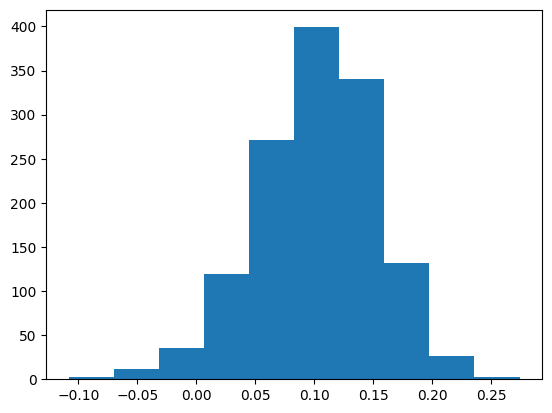

In [54]:
plt.hist(sentiment.ts_polarity)
plt.show()

## Stock

In [55]:
stock = pd.read_csv("AAPL-stock.csv", parse_dates=['date'])

In [56]:
stock.head()

,date,close,volume,open,high,low
0,2020-02-28,273.36,106721200,257.26,278.41,256.37
1,2020-02-27,273.52,80151380,281.10,286.00,272.96
2,2020-02-26,292.65,49678430,286.53,297.88,286.50
3,2020-02-25,288.08,57668360,300.95,302.53,286.13
4,2020-02-24,298.18,55548830,297.26,304.18,289.23


## Merge data

In [57]:
df = pd.merge(sentiment, stock, how='inner', on='date')

In [58]:
df.head()

,date,ts_polarity,twitter_volume,close,volume,open,high,low
0,2016-01-04,0.070389,1133,105.35,67569090,102.61,105.368,102.00
1,2016-01-05,0.133635,1430,102.71,55583140,105.75,105.850,102.41
2,2016-01-06,0.072042,1949,100.70,68384270,100.56,102.370,99.87
3,2016-01-07,0.074369,2289,96.45,80742460,98.68,100.130,96.43
4,2016-01-08,0.051595,2235,96.96,70722000,98.55,99.110,96.76


In [59]:
df.tail()

,date,ts_polarity,twitter_volume,close,volume,open,high,low
917,2019-08-26,0.072340,888,206.49,26066130,205.86,207.19,205.0573
918,2019-08-27,0.117541,962,204.16,25897340,207.86,208.55,203.5300
919,2019-08-28,0.061477,895,205.53,15957630,204.10,205.72,203.3200
920,2019-08-29,0.056460,1083,209.01,21007650,208.50,209.32,206.6550
921,2019-08-30,0.106096,1005,208.74,21162560,210.16,210.45,207.2000


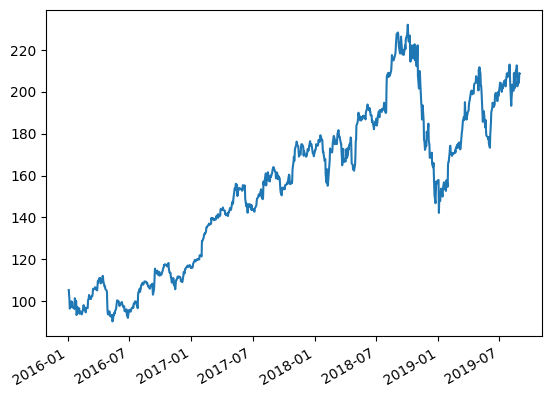

In [60]:
plt.plot(df.date, df.close)
plt.gcf().autofmt_xdate()
plt.show()

In [61]:
df.corr(numeric_only=True)

,ts_polarity,twitter_volume,close,volume,open,high,low
ts_polarity,1.000000,-0.299737,0.507260,-0.182254,0.505935,0.505000,0.509161
twitter_volume,-0.299737,1.000000,-0.277655,0.583901,-0.276811,-0.271618,-0.282240
close,0.507260,-0.277655,1.000000,-0.214462,0.998843,0.999397,0.999479
volume,-0.182254,0.583901,-0.214462,1.000000,-0.209238,-0.199500,-0.224998
open,0.505935,-0.276811,0.998843,-0.209238,1.000000,0.999498,0.999319
high,0.505000,-0.271618,0.999397,-0.199500,0.999498,1.000000,0.999183
low,0.509161,-0.282240,0.999479,-0.224998,0.999319,0.999183,1.000000


## Model

In [62]:
def window_data(df, window, feature_cols: tuple[str], target_col):
    X_feat = [[] for _ in feature_cols]

    y = []
    for i in range(len(df) - window):
        for feat_id, feature_col_name in enumerate(feature_cols):
            feat_value = df.iloc[i:(i + window), df.columns.get_loc(feature_col_name)]
            X_feat[feat_id].append(feat_value)

        target = df.iloc[(i + window), df.columns.get_loc(target_col)] # j + 1
        y.append(target)
        
    return np.hstack(X_feat), np.array(y).reshape(-1, 1)

In [63]:
# Predict j+1 target using a "window_size"-day window of previous closing prices
window_size = 1

X, y = window_data(df, window_size, ("ts_polarity", "twitter_volume", "close"), "close")

We take the features of n days to make a prediction at j + 1 after those n days

In [64]:
df.head()

,date,ts_polarity,twitter_volume,close,volume,open,high,low
0,2016-01-04,0.070389,1133,105.35,67569090,102.61,105.368,102.00
1,2016-01-05,0.133635,1430,102.71,55583140,105.75,105.850,102.41
2,2016-01-06,0.072042,1949,100.70,68384270,100.56,102.370,99.87
3,2016-01-07,0.074369,2289,96.45,80742460,98.68,100.130,96.43
4,2016-01-08,0.051595,2235,96.96,70722000,98.55,99.110,96.76


```
So for 3 days we have X[0] = [ts_polarity[0], ts_polarity[1], ts_polarity[2],
                              twitter_vol[0], twitter_vol[1], twitter_vol[2],
                              ...
                              close[0], close[1], close[2]]

And y[0] = close[3]
```

In [65]:
X[0]

array([7.03887781e-02, 1.13300000e+03, 1.05350000e+02])

In [66]:
y[0]

array([102.71])

### Training

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0, shuffle=False)

In [68]:
from sklearn.preprocessing import MinMaxScaler

# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [69]:
from xgboost import XGBRegressor

# Create the XG Boost regressor instance
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [70]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Performance

In [71]:
from sklearn import metrics

In [72]:
# Make some predictions
predicted = model.predict(X_test)

In [73]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.043253718731446754
R-squared : 0.9630145157667405


In [74]:
# Recover the original prices instead of the scaled version
predicted_prices = y_train_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1, 1))

In [75]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
618,144.016480,144.402390
619,140.499546,143.769516
620,141.433551,141.682953
621,140.234335,141.432861
622,139.611664,141.365082


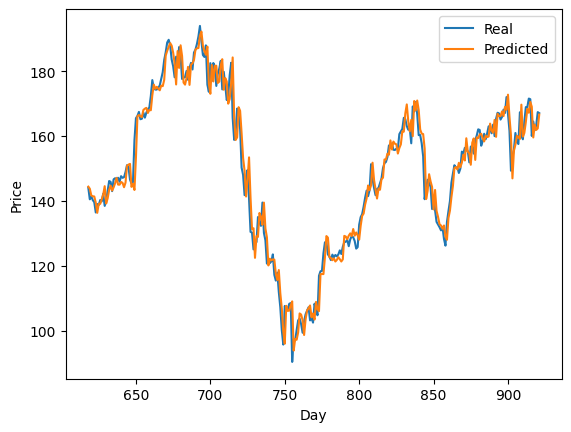

In [76]:
# Plot the real vs predicted values as a line chart
#plt.plot(y_train, label="Train")
plt.plot(stocks.Real, label="Real")
plt.plot(stocks.Predicted, label="Predicted")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

## Export model

In [77]:
import joblib

In [78]:
joblib.dump(model, 'stock_prediction.joblib')
joblib.dump(y_train_scaler, 'stock_prediction_y_scaler.joblib')
joblib.dump(x_train_scaler, 'stock_prediction_x_scaler.joblib')

['stock_prediction_x_scaler.joblib']